#Devoir classifiacation : groupe 5


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV


# Étape 1 : Chargement des données
df = pd.read_csv('/content/farms_train.csv', sep=';', decimal=',')

# Afficher les premières lignes pour vérifier la structure des données
df.head()

,DIFF,R2,R7,R8,R17,R22,R32
0,0,"0,705","0,29","0,1334","0,0481","0,5258","0,2941"
1,1,"0,801","0,213","0,1282","0,0186","2,1411","0,3005"
2,1,"0,591","0,429","0,2999","0,08","0,5957","0,4126"
3,0,"0,373","0,346","1,3704","0,0812","0,343","0,2265"
4,0,0,"1,417","0,2493","0,0501","0,8728","0,1086"


In [ ]:
# Afficher les NAN pour le traitement des données
df.isna().sum()

# Identifier les colonnes de type 'object'
object_columns = df.select_dtypes(include=['object']).columns

# Nettoyer et convertir les colonnes de type 'object' en float
for col in object_columns:
    df[col] = df[col].str.replace(',', '.').str.strip()  # Remplacer ',' par '.' si nécessaire
    df[col] = pd.to_numeric(df[col], errors='coerce')    # Convertir en float, NaN pour erreurs

# Vérifier les types après la conversion
print(df.dtypes)

DIFF      int64
R2      float64
R7      float64
R8      float64
R17     float64
R22     float64
R32     float64
dtype: object


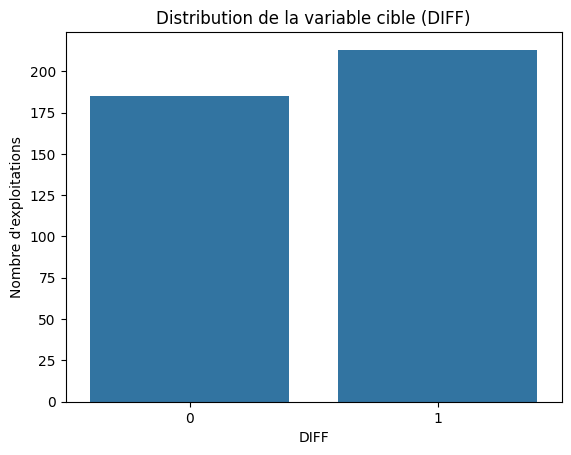

In [ ]:
# Visualisation de la distribution de la variable cible
sns.countplot(x='DIFF', data=df)
plt.title('Distribution de la variable cible (DIFF)')
plt.xlabel('DIFF')
plt.ylabel('Nombre d\'exploitations')
plt.show()

<Figure size 1400x800 with 0 Axes>

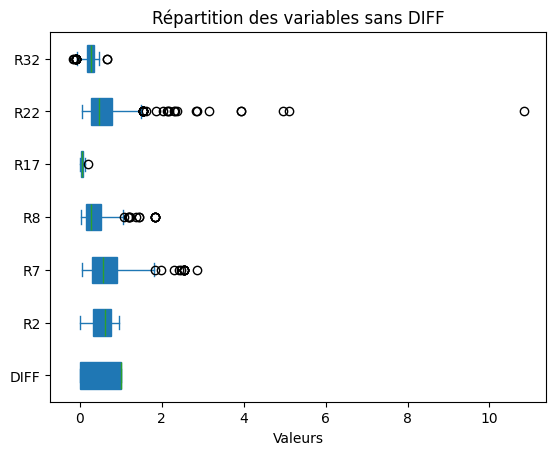

In [ ]:
# Variables explicatives
# Visualisation avec des boîtes à moustaches
plt.figure(figsize=(14, 8))
df.plot(kind='box', vert=False, patch_artist=True, showfliers=True)
plt.xlabel('Valeurs')
plt.title('Répartition des variables sans DIFF')
plt.show()

Suppression d'un point trop influent


In [ ]:
df.R22.describe()

,R22
count,398.000000
mean,0.673835
std,0.797979
min,0.055390
25%,0.285525
50%,0.480500
75%,0.782050
max,10.840000


In [ ]:
idR22 = df.R22.idxmax()
df = df.drop(49)

In [ ]:
df.R22.describe()

,R22
count,397.000000
mean,0.648228
std,0.613786
min,0.055390
25%,0.285200
50%,0.479300
75%,0.779800
max,5.110900


<Figure size 1400x800 with 0 Axes>

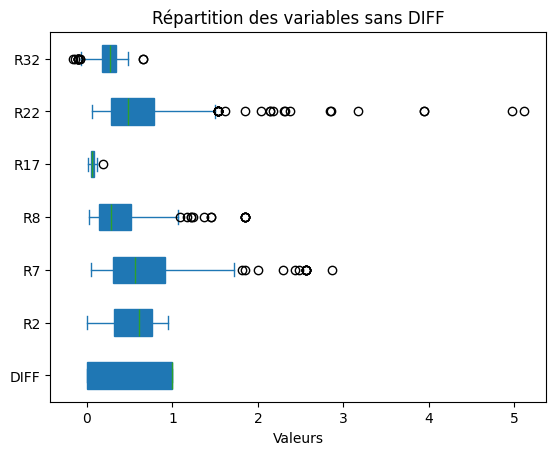

In [ ]:
# Visualisation avec des boîtes à moustaches
plt.figure(figsize=(14, 8))
df.plot(kind='box', vert=False, patch_artist=True, showfliers=True)
plt.xlabel('Valeurs')
plt.title('Répartition des variables sans DIFF')
plt.show()

# Selection de variables : ACP

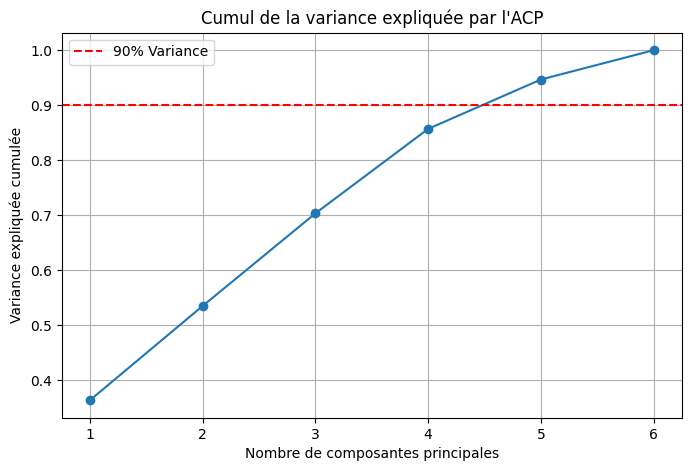

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalisation des données explicatives
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X correspond à vos variables explicatives

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Application de l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Visualisation de la variance expliquée par composante
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.title('Cumul de la variance expliquée par l\'ACP')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.legend()
plt.grid()
plt.show()



On decide de garder les 4 premiere composante principale

In [ ]:
# Réduction à k composantes principales
k = 4
pca = PCA(n_components=k)
X_reduced = pca.fit_transform(X_scaled)

# Charges factorielles : influence des variables sur les composantes principales
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(k)], index=X.columns)
print(loadings)



          PC1       PC2       PC3       PC4
R2   0.577125  0.173581  0.054708  0.068211
R7  -0.544366 -0.280680 -0.010907 -0.320985
R8  -0.018226  0.151393  0.975378 -0.048666
R17 -0.300155  0.330537 -0.047593  0.838107
R22 -0.085765  0.858470 -0.184788 -0.433040
R32  0.522314 -0.148133 -0.095473 -0.001081


## Première Partie : Mise en place d’un modèle naïf
Pour établir une baseline, nous avons construit un modèle naïf simple afin de prédire si une exploitation agricole est financièrement saine (DIFF = 1) ou défaillante (DIFF = 0).

On a décidé de realisé un classificateur de Bayes



In [ ]:
# Division du dataset en train/test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Création et entraînement du classificateur Naïve Bayes
model = GaussianNB()
model.fit(X_train, y_train)

# Prédictions
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilité d'appartenance à la classe 1 (DIFF = 1)

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC du modèle Naïve Bayes avec ACP (k=4) :", auc)

AUC du modèle Naïve Bayes avec ACP (k=4) : 0.8966425279789334


#KNN

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Séparation des variables indépendantes (X) et la variable dépendante (y)
X = df.drop('DIFF', axis=1)  # Remplacez 'DIFF' par le nom de la colonne cible si différent
y = df['DIFF']

# Diviser les données en un ensemble de train et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardiser les features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Réduction dimensionnelle avec ACP (k=4)
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Recherche du meilleur nombre de voisins (k) à l'aide de la validation croisée
best_k = None
best_auc = 0
k_range = range(1, 31)  # Tester les valeurs de k de 1 à 30

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Utiliser les données après réduction avec ACP
    cv_scores = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='roc_auc')
    mean_auc = np.mean(cv_scores)
    print(f"k={k}, Validation croisée AUC moyenne : {mean_auc:.4f} ± {np.std(cv_scores):.4f}")

    if mean_auc > best_auc:
        best_k = k
        best_auc = mean_auc

print(f"Meilleur k : {best_k} avec une AUC moyenne de validation croisée de {best_auc:.4f}")

# Évaluer le modèle KNN avec le meilleur k sur l'ensemble de test
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_pca, y_train)
y_test_proba = knn_best.predict_proba(X_test_pca)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"AUC sur l'ensemble de test avec k={best_k} : {test_auc:.4f}")


k=1, Validation croisée AUC moyenne : 0.7653 ± 0.0457
k=2, Validation croisée AUC moyenne : 0.8289 ± 0.0090
k=3, Validation croisée AUC moyenne : 0.8712 ± 0.0262
k=4, Validation croisée AUC moyenne : 0.8765 ± 0.0216
k=5, Validation croisée AUC moyenne : 0.8803 ± 0.0196
k=6, Validation croisée AUC moyenne : 0.8835 ± 0.0205
k=7, Validation croisée AUC moyenne : 0.8828 ± 0.0251
k=8, Validation croisée AUC moyenne : 0.8790 ± 0.0253
k=9, Validation croisée AUC moyenne : 0.8795 ± 0.0213
k=10, Validation croisée AUC moyenne : 0.8834 ± 0.0204
k=11, Validation croisée AUC moyenne : 0.8883 ± 0.0209
k=12, Validation croisée AUC moyenne : 0.8843 ± 0.0196
k=13, Validation croisée AUC moyenne : 0.8846 ± 0.0199
k=14, Validation croisée AUC moyenne : 0.8845 ± 0.0193
k=15, Validation croisée AUC moyenne : 0.8861 ± 0.0192
k=16, Validation croisée AUC moyenne : 0.8871 ± 0.0215
k=17, Validation croisée AUC moyenne : 0.8883 ± 0.0214
k=18, Validation croisée AUC moyenne : 0.8893 ± 0.0217
k=19, Validation cr

In [ ]:
# Entraîner le modèle avec le meilleur k sur l'ensemble d'entraînement complet
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Prédictions sur les données de test
y_pred_proba = knn.predict_proba(X_test_scaled)[:, 1]  # Proba pour la classe 1

# Calculer l'AUC sur l'ensemble de test
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC sur l\'ensemble de test avec k={best_k} : {auc:.4f}')

AUC sur l'ensemble de test avec k=29 : 0.8623


Les KNN (k-Nearest Neighbors) ne fournissent pas directement de probabilités, car leur fonctionnement repose sur la proximité entre les points dans l’espace des features. Cependant, ils permettent de générer les probabilités nécessaires au calcul de l’AUC grâce à une méthode simple. Pour chaque observation, le modèle identifie ses k voisins les plus proches et calcule la probabilité d’appartenance à une classe comme étant la proportion des voisins appartenant à cette classe. Par exemple, si k = 5 et que 3 des 5 voisins appartiennent à la classe positive, alors la probabilité d’appartenance à cette classe est de 0,6.

Ces probabilités sont ensuite utilisées pour tracer la courbe ROC, et l’AUC est déterminée comme l’aire sous cette courbe. L’AUC permet de mesurer la capacité du modèle à différencier les classes positives et négatives. Ainsi, les probabilités calculées par les KNN reflètent simplement la proportion de voisins associés à chaque classe.

# Regression logistique


In [ ]:
# Définir la grille d'hyperparamètres
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga', 'liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500],
}

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Meilleurs paramètres : {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Meilleure AUC : 0.9334759358288771


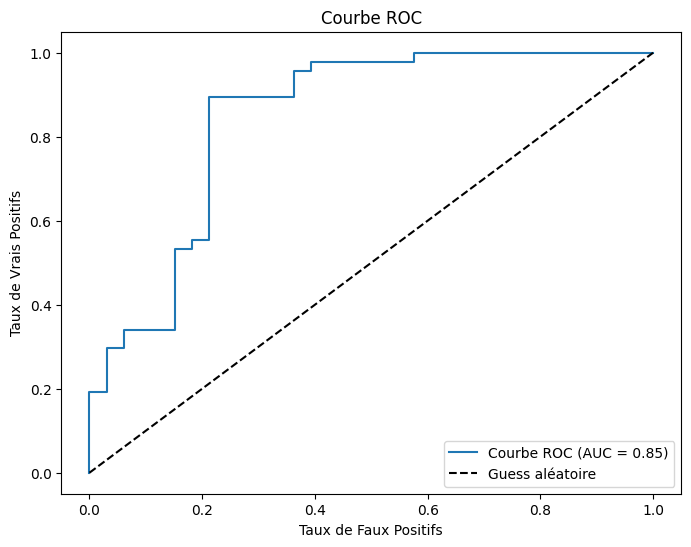

In [ ]:
# Séparation des données des ensembles d'entraînement et de test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle
model = LogisticRegression()

# Recherche de grille
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et score
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure AUC :", grid_search.best_score_)

# Prédictions sur le jeu de validation
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Tracé de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Guess aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()